In [74]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import multivariate_normal, normal


def ed_eigvecs(eigvecs):
    eigvals = np.linalg.norm(eigvecs, axis=1) ** 2
    return eigvals.sum() ** 2 / (eigvals ** 2).sum()


def ed_empirical(X):
    eigvals = PCA().fit(X).explained_variance_
    return eigvals.sum() ** 2 / (eigvals ** 2).sum()


def eigvecs_empirical(X):
    pca = PCA().fit(X)
    eigvecs = pca.components_
    eigvals = pca.explained_variance_
    eigvecs = eigvecs * np.sqrt(eigvals).reshape(2, 1)
    return eigvecs

---
# With noise

In [80]:
latent = normal(0, 1, size=(1000, 2))
noise_std = 0.25

high_dim_eigvecs = np.array([[1, 0], 
                             [0, 0.75]])
high_dim = latent @ high_dim_eigvecs.T

low_dim_eigvecs = np.array([[1 / np.sqrt(2), 1 / np.sqrt(2)], 
                             [-1 / np.sqrt(32), 1 / np.sqrt(32)]])
low_dim = latent @ low_dim_eigvecs.T

model_low_to_high = LinearRegression().fit(low_dim + normal(0, noise_std, size=(1000, 2)), high_dim + normal(0, noise_std, size=(1000, 2)))
res_low_to_high = high_dim + normal(0, noise_std, size=(1000, 2)) - model_low_to_high.predict(low_dim + normal(0, noise_std, size=(1000, 2)))
res_low_to_high_eigvecs = eigvecs_empirical(res_low_to_high)

model_high_to_low = LinearRegression().fit(high_dim + normal(0, noise_std, size=(1000, 2)), low_dim + normal(0, noise_std, size=(1000, 2)))
res_high_to_low = low_dim + normal(0, noise_std, size=(1000, 2)) - model_high_to_low.predict(high_dim + normal(0, noise_std, size=(1000, 2)))
res_high_to_low_eigvecs = eigvecs_empirical(res_high_to_low)

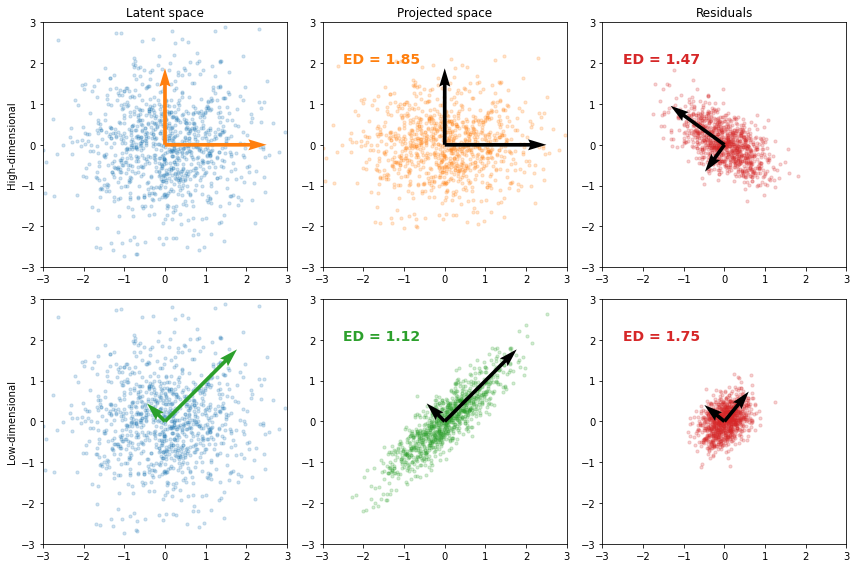

In [81]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
colors = sns.color_palette()[:4]

# Mappings back to original space
to_high = (high_dim_eigvecs / np.linalg.norm(high_dim_eigvecs, axis=1, keepdims=True))
to_low = (low_dim_eigvecs / np.linalg.norm(low_dim_eigvecs, axis=1, keepdims=True))
high_proj = high_dim @ to_high
low_proj = low_dim @ to_low
res_low_to_high_proj = res_low_to_high @ to_high
res_high_to_low_proj = res_high_to_low @ to_low
res_low_to_high_eigvecs_proj = res_low_to_high_eigvecs @ to_high
res_high_to_low_eigvecs_proj = res_high_to_low_eigvecs @ to_low

# Latent space
axs[0, 0].scatter(latent[:, 0], latent[:, 1], color=colors[0], alpha=0.2, s=10)
axs[0, 0].quiver([0, 0], [0, 0], high_dim_eigvecs[:, 0], high_dim_eigvecs[:, 1], 
                 scale_units='xy', scale=.4, width=.015, color=colors[1])
axs[0, 0].set(xlim=(-3, 3), ylim=(-3, 3), ylabel='High-dimensional', title='Latent space')

axs[1, 0].scatter(latent[:, 0], latent[:, 1], color=colors[0], alpha=0.2, s=10)
axs[1, 0].quiver([0, 0], [0, 0], low_dim_eigvecs[:, 0], low_dim_eigvecs[:, 1], 
                 scale_units='xy', scale=.4, width=.015, color=colors[2])
axs[1, 0].set(xlim=(-3, 3), ylim=(-3, 3), ylabel='Low-dimensional')

# Projected space
axs[0, 1].scatter(high_proj[:, 0], high_proj[:, 1], color=colors[1], alpha=0.2, s=10)
axs[0, 1].quiver([0, 0], [0, 0], high_dim_eigvecs[:, 0], high_dim_eigvecs[:, 1], 
                 scale_units='xy', scale=.4, width=.015)
axs[0, 1].text(-2.5, 2, f'ED = {ed_eigvecs(high_dim_eigvecs):.2f}', color=colors[1], weight='bold', fontsize=14)
axs[0, 1].set(xlim=(-3, 3), ylim=(-3, 3), title='Projected space')

axs[1, 1].scatter(low_proj[:, 0], low_proj[:, 1], color=colors[2], alpha=0.2, s=10)
axs[1, 1].quiver([0, 0], [0, 0], low_dim_eigvecs[:, 0], low_dim_eigvecs[:, 1], 
                 scale_units='xy', scale=.4, width=.015)
axs[1, 1].text(-2.5, 2, f'ED = {ed_eigvecs(low_dim_eigvecs):.2f}', color=colors[2], weight='bold', fontsize=14)
axs[1, 1].set(xlim=(-3, 3), ylim=(-3, 3))

# Residuals
axs[0, 2].scatter(res_low_to_high_proj[:, 0], res_low_to_high_proj[:, 1], color=colors[3], alpha=0.2, s=10)
axs[0, 2].quiver([0, 0], [0, 0], res_low_to_high_eigvecs_proj[:, 0], res_low_to_high_eigvecs_proj[:, 1], 
                 scale_units='xy', scale=.4, width=.015)
axs[0, 2].text(-2.5, 2, f'ED = {ed_empirical(res_low_to_high):.2f}', color=colors[3], weight='bold', fontsize=14)
axs[0, 2].set(xlim=(-3, 3), ylim=(-3, 3), title='Residuals')

axs[1, 2].scatter(res_high_to_low_proj[:, 0], res_high_to_low_proj[:, 1], color=colors[3], alpha=0.2, s=10)
axs[1, 2].quiver([0, 0], [0, 0], res_high_to_low_eigvecs_proj[:, 0], res_high_to_low_eigvecs_proj[:, 1], 
                 scale_units='xy', scale=.4, width=.015)
axs[1, 2].text(-2.5, 2, f'ED = {ed_empirical(res_high_to_low):.2f}', color=colors[3], weight='bold', fontsize=14)
axs[1, 2].set(xlim=(-3, 3), ylim=(-3, 3))

fig.tight_layout()
plt.show()